In [1]:
from keras import layers
import keras
from google.colab import drive
drive.mount('/content/drive/')
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed
from PIL import Image

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
image_dir = '/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Datasets/BDD100k/bdd100k/bdd100k/images/100k/daytime'
mask_dir = '/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Datasets/BDD100k/bdd100k_ins_seg/bdd100k/labels/ins_seg/colormaps/daytime'

In [3]:
import os
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_image_mask_pair(image_path, mask_path, target_size=(256, 256), num_classes=19):
    # Read and resize image
    img = cv2.imread(image_path, cv2.IMREAD_REDUCED_COLOR_2)  # Read at reduced size
    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    img_normalized = (img_resized / 255.0).astype(np.float32)

    # Read and resize mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    mask_normalized = (mask_resized > 127).astype(np.float32)

    # Preprocess category IDs and one-hot encode the mask
    # category_ids = np.clip(mask_resized, 0, num_classes - 1)
    # encoded_mask = np.eye(num_classes, dtype=np.float32)[category_ids]

    return img_normalized, mask_normalized



def load_and_clean_data(image_dir, mask_dir, target_size=(256, 256), num_classes=1, max_images=1000):
    image_files = {os.path.splitext(f)[0]: f for f in sorted(os.listdir(image_dir))}
    mask_files = {os.path.splitext(f)[0]: f for f in sorted(os.listdir(mask_dir))}

    # Identify and delete unmatched files
    unmatched_images = set(image_files.keys()) - set(mask_files.keys())
    unmatched_masks = set(mask_files.keys()) - set(image_files.keys())

    for unmatched_img in unmatched_images:
        os.remove(os.path.join(image_dir, image_files[unmatched_img]))
        print(f"Deleted unmatched image: {image_files[unmatched_img]}")

    for unmatched_mask in unmatched_masks:
        os.remove(os.path.join(mask_dir, mask_files[unmatched_mask]))
        print(f"Deleted unmatched mask: {mask_files[unmatched_mask]}")

    # Process matched files
    matched_keys = list(set(image_files.keys()) & set(mask_files.keys()))[:max_images]

    images = []
    masks = []

    with ThreadPoolExecutor() as executor:
        future_to_key = {executor.submit(process_image_mask_pair,
                                         os.path.join(image_dir, image_files[img_name]),
                                         os.path.join(mask_dir, mask_files[img_name]),
                                         target_size,
                                         num_classes): img_name for img_name in matched_keys}

        for i, future in enumerate(as_completed(future_to_key)):
            img, mask = future.result()
            images.append(img)
            masks.append(mask)

            if (i + 1) % 100 == 0:
                print(f"Loaded {i + 1} image-mask pairs.")

    return np.array(images), np.array(masks)

In [4]:
images, masks = load_and_clean_data(image_dir, mask_dir, target_size=(256, 256), num_classes=1, max_images=1000)

Loaded 100 image-mask pairs.
Loaded 200 image-mask pairs.
Loaded 300 image-mask pairs.
Loaded 400 image-mask pairs.
Loaded 500 image-mask pairs.
Loaded 600 image-mask pairs.
Loaded 700 image-mask pairs.
Loaded 800 image-mask pairs.
Loaded 900 image-mask pairs.
Loaded 1000 image-mask pairs.


In [5]:
images.shape

(1000, 256, 256, 3)

In [6]:
masks.shape

(1000, 256, 256)

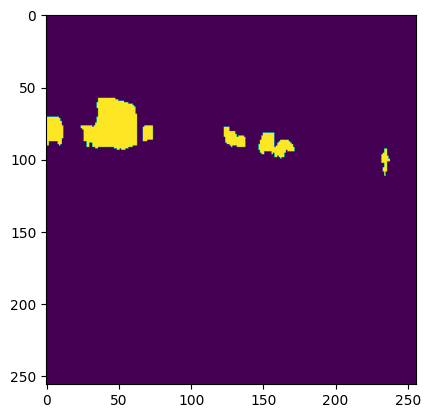

In [7]:
plt.imshow(masks[7])

In [8]:
import tensorflow as tf

def improved_unet(img_size=(256, 256, 3), num_classes=1):
    inputs = keras.Input(shape=img_size)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)
    # Define the model
    model = keras.Model(inputs, outputs)
    return model

    # # Encoder (Pre-trained Backbone)
    # base_model = tf.keras.applications.MobileNetV2(input_shape=input_size, include_top=False, weights='imagenet')

    # # Encoder layers corresponding to the output shapes in the provided architecture
    # layer_names = [
    #     'block_1_expand_relu',   # 128x128
    #     'block_3_expand_relu',   # 64x64
    #     'block_6_expand_relu',   # 32x32
    #     'block_13_expand_relu',  # 16x16
    #     'block_16_project',      # 8x8
    # ]
    # layers = [base_model.get_layer(name).output for name in layer_names]
    # encoder = tf.keras.Model(inputs=base_model.input, outputs=layers)

    # # Decoder (Upsampling)
    # inputs = tf.keras.layers.Input(shape=input_size)
    # encoder_outputs = encoder(inputs)

    # # Start with the smallest feature map (8x8)
    # x = encoder_outputs[-1]
    # x = tf.keras.layers.Conv2DTranspose(2048, (3, 3), strides=2, padding="same")(x)  # Upsample to 16x16
    # x = tf.keras.layers.concatenate([x, encoder_outputs[-2]])  # Skip connection (16x16)
    # x = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.BatchNormalization()(x)

    # x = tf.keras.layers.Conv2DTranspose(1024, (3, 3), strides=2, padding="same")(x)  # Upsample to 32x32
    # x = tf.keras.layers.concatenate([x, encoder_outputs[-3]])  # Skip connection (32x32)
    # x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.BatchNormalization()(x)

    # x = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=2, padding="same")(x)  # Upsample to 64x64
    # x = tf.keras.layers.concatenate([x, encoder_outputs[-4]])  # Skip connection (64x64)
    # x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.BatchNormalization()(x)

    # x = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=2, padding="same")(x)  # Upsample to 128x128
    # x = tf.keras.layers.concatenate([x, encoder_outputs[-5]])  # Skip connection (128x128)
    # x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.BatchNormalization()(x)

    # # Final upsampling layer to get the output shape (256x256)
    # x = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)  # Upsample to 256x256
    # x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.BatchNormalization()(x)

    # # Output layer (256x256x1)
    # outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)  # Use 'sigmoid' for binary output

    # model = tf.keras.Model(inputs=inputs, outputs=outputs)
    # return model

# Training setup
def get_model(input_size=(256, 256, 3)):
    model = improved_unet(input_size)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=lambda y_true, y_pred: tf.keras.losses.BinaryCrossentropy()(y_true, y_pred) + dice_loss(y_true, y_pred),
                  metrics=['accuracy', dice_loss])
    return model

# Dice loss and combined loss functions
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return 1 - dice

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

In [9]:
# def improved_unet(input_size=(256, 256, 1)):
#     base_model = tf.keras.applications.MobileNetV2(input_shape=input_size, include_top=False, weights='imagenet')

#     # Encoder (Pre-trained Backbone)
#     layer_names = [
#         'block_1_expand_relu',   # 128x128
#         'block_3_expand_relu',   # 64x64
#         'block_6_expand_relu',   # 32x32
#         'block_13_expand_relu',  # 16x16
#         'block_16_project',      # 8x8
#     ]
#     layers = [base_model.get_layer(name).output for name in layer_names]
#     encoder = tf.keras.Model(inputs=base_model.input, outputs=layers)

#     inputs = tf.keras.layers.Input(shape=input_size)
#     encoder_outputs = encoder(inputs)

#     # Decoder (Upsampling)
#     x = encoder_outputs[-1]
#     for i in range(5, 0, -1):
#         x = tf.keras.layers.Conv2DTranspose(
#             filters=256 // (2**(5-i)),
#             kernel_size=(3, 3),
#             strides=2,
#             padding="same"
#         )(x)
#         if i > 1:
#             x = tf.keras.layers.concatenate([x, encoder_outputs[i-2]])
#         x = tf.keras.layers.Conv2D(256 // (2**(5-i)), (3, 3), activation='relu', padding='same')(x)
#         x = tf.keras.layers.BatchNormalization()(x)
#         x = tf.keras.layers.Conv2D(256 // (2**(5-i)), (3, 3), activation='relu', padding='same')(x)
#         x = tf.keras.layers.BatchNormalization()(x)

#     # Final layer
#     outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='relu')(x)

#     model = tf.keras.Model(inputs=inputs, outputs=outputs)
#     return model

# def dice_loss(y_true, y_pred, smooth=1e-6):
#     y_true_f = tf.keras.backend.flatten(y_true)
#     y_pred_f = tf.keras.backend.flatten(y_pred)
#     intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
#     dice = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
#     return 1 - dice

# # Training setup
# def get_model(input_size=(256, 256, 3)):
#     model = improved_unet(input_size)
#     model.compile(optimizer=tf.keras.optimizers.Adam(),
#                   loss=lambda y_true, y_pred: tf.keras.losses.BinaryCrossentropy()(y_true, y_pred) + dice_loss(y_true, y_pred),
#                   # loss='binary_crossentropy',
#                   metrics=['accuracy'],
#                   )
#     return model

# # Data augmentation
# def augment_data(images, masks, batch_size=32):
#     """
#     Applies data augmentation and returns a combined generator yielding (image, mask) tuples.

#     Args:
#         images (numpy array): Array of images.
#         masks (numpy array): Array of ground truth masks.
#         batch_size (int): Batch size for the generator.

#     Returns:
#         generator: A generator that yields (image, mask) tuples.
#         int: Batch size.
#     """
#     # Create ImageDataGenerator for data augmentation
#     datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#         rotation_range=20,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest'
#     )

#     # Create a flow for images and masks, combining them with zip
#     image_flow = datagen.flow(images, batch_size=batch_size, seed=42)
#     mask_flow = datagen.flow(masks, batch_size=batch_size, seed=42)

#     # Create a combined generator that yields tuples of (image, mask)
#     def combined_generator(image_gen, mask_gen):
#         while True:
#             # Get the next batch of images and masks
#             image_batch = next(image_gen)
#             mask_batch = next(mask_gen)
#             # Yield the image and mask as a tuple
#             yield (image_batch, mask_batch)

#     # Return the combined generator and batch size
#     return combined_generator(image_flow, mask_flow), batch_size

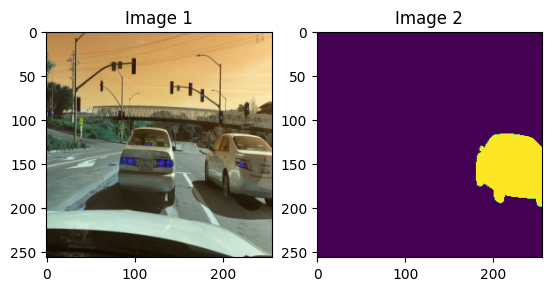

In [10]:
fig, axs = plt.subplots(1, 2)
idx = np.random.randint(0, len(images))
# Plot the image pairs
axs[0].imshow(images[idx])
axs[0].set_title('Image 1')
axs[1].imshow(masks[idx].squeeze())
axs[1].set_title('Image 2')

plt.show()

In [11]:
masks = masks.reshape(-1, 256, 256, 1)

In [12]:
# train_flow, batch_size = augment_data(images, masks)

In [13]:
# model = improved_unet(input_size=(256, 256, 3))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
model = get_model()

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 32)   │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 128, 128, 64)   │          2,400 │ activation_1[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 128, 128, 64)   │          4,736 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 64)   │            256 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 64)     │          2,112 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 64)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 64, 64, 128)    │          8,896 │ activation_3[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 2,058,401 (7.85 MB)

 Trainable params: 2,054,625 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [16]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
        ]

In [17]:
# images = tf.cast(images, tf.float32)
# masks = tf.cast(masks, tf.float32)

In [18]:
history = model.fit(x=images, y=masks, epochs=50, batch_size=32)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 939ms/step - accuracy: 0.8538 - dice_loss: 0.9039 - loss: 2.2750
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.9279 - dice_loss: 0.7759 - loss: 1.0068
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - accuracy: 0.9349 - dice_loss: 0.7098 - loss: 0.9087
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - accuracy: 0.9376 - dice_loss: 0.6839 - loss: 0.8769
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.9381 - dice_loss: 0.6815 - loss: 0.8617
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - accuracy: 0.9395 - dice_loss: 0.6133 - loss: 0.8002
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.9399 - dice_loss: 0.5885 - loss: 0.7775
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.9502 - dice_loss: 0.5296 - loss: 0.6894
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 245ms/step - accuracy: 0.9583 - dice_loss: 0.4862 - loss: 0.6280
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 

In [19]:
predicted_mask = model.predict(images)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step


In [20]:
def plot_images_masks_predictions(images, masks, predictions, indexes):
    """
    Plots specific samples of images, corresponding masks, and predicted masks.

    Args:
        images (numpy array): Array of images.
        masks (numpy array): Array of ground truth masks.
        predictions (numpy array): Array of predicted masks.
        indexes (list): List of indexes of images to display.
    """
    num_samples = len(indexes)
    plt.figure(figsize=(10, num_samples * 3))

    for i, idx in enumerate(indexes):
        # Ensure the index is within bounds
        if idx < 0 or idx >= len(images):
            print(f"Index {idx} is out of bounds. Skipping.")
            continue

        # Image
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(images[idx])
        plt.title(f"Image {idx}")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(masks[idx].squeeze(), cmap='gray')
        plt.title(f"Ground Truth Mask {idx}")
        plt.axis("off")

        # Predicted mask
        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(predictions[idx].squeeze(), cmap='gray')
        plt.title(f"Predicted Mask {idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

[ 17  55  81 114 151 163 203 294 354 447 460 485 537 552 558 673 723 772
 801 906]


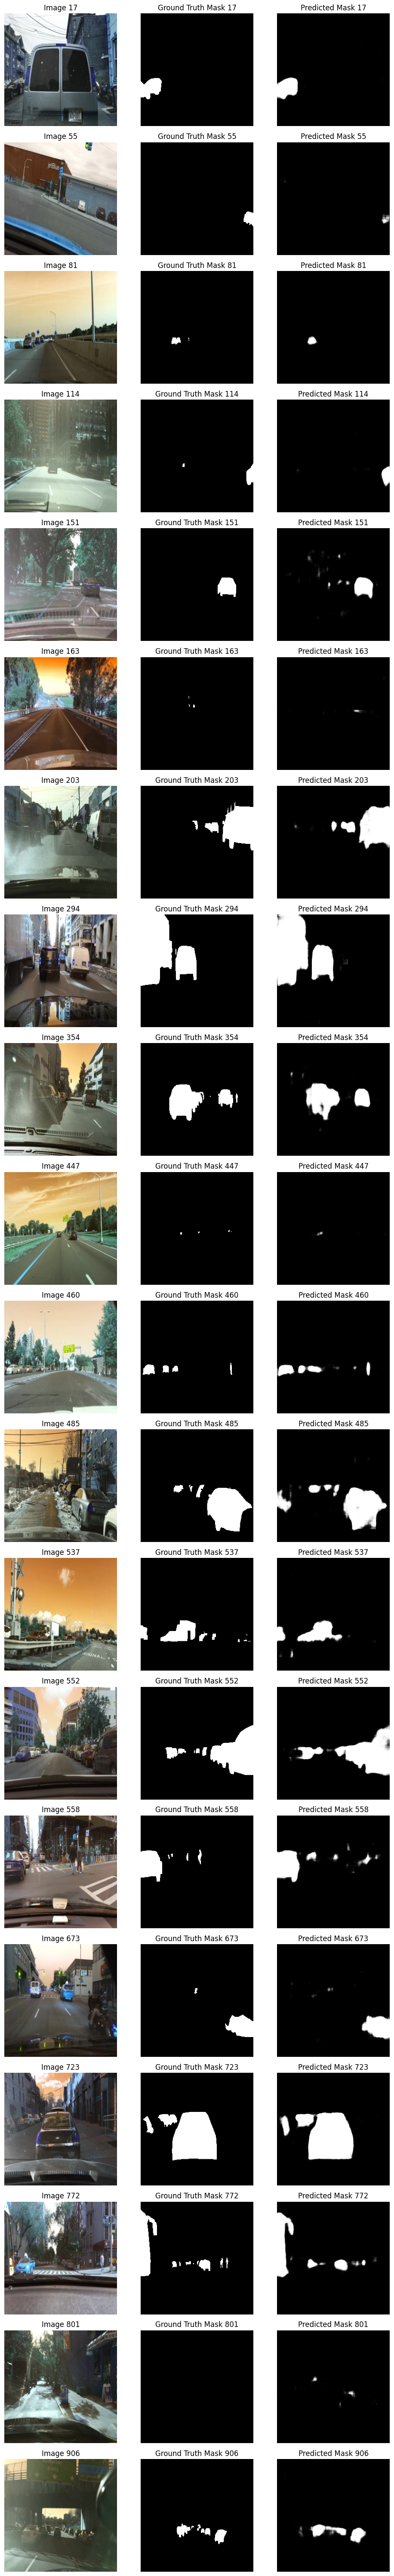

In [21]:
idxs = np.random.randint(0, len(images), 20)
# idxs = np.array([10, 38, 45, 48, 46, 17, 72, 24, 79, 81, 88, 98, 93])
idxs = np.sort(idxs)
print(idxs)
plot_images_masks_predictions(images, masks, predicted_mask, indexes=idxs)

In [22]:
model.save("/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Models/Xception_unet_3.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:                   loss=lambda y_true, y_pred: tf.keras.losses.BinaryCrossentropy()(y_true, y_pred) + dice_loss(y_true, y_pred),

  return {key: serialize_keras_object(value) for key, value in obj.items()}


# Testing for Nighttime

In [23]:
def load_pretrained_model(model_path):

  def dice_loss(y_true, y_pred, smooth=1e-6):
      y_true_f = tf.keras.backend.flatten(y_true)
      y_pred_f = tf.keras.backend.flatten(y_pred)
      intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
      dice = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
      return 1 - dice

  def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

  new_model = tf.keras.models.load_model(
      model_path,
      custom_objects={'dice_loss': dice_loss,'combined_loss': combined_loss },
      safe_mode=False  # Allow lambda loading
  )

  return new_model

In [24]:
new_model = load_pretrained_model("/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Models/Xception_unet_3.keras")

In [25]:
image_folder = "/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Datasets/BDD100k/bdd100k/bdd100k/images/100k/night"
mask_folder = "/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Datasets/BDD100k/bdd100k_ins_seg/bdd100k/labels/ins_seg/colormaps/night"

In [26]:
images, masks = load_and_clean_data(image_folder, mask_folder)

Loaded 100 image-mask pairs.


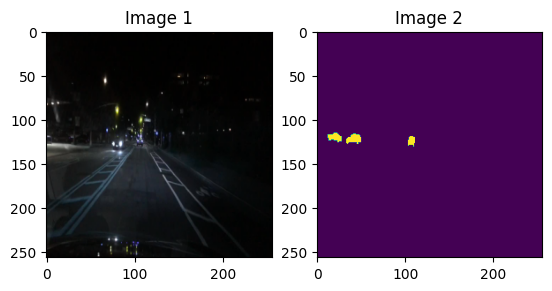

In [28]:
fig, axs = plt.subplots(1, 2)
idx = np.random.randint(0, len(images))
# Plot the image pairs
axs[0].imshow(images[idx])
axs[0].set_title('Image 1')
axs[1].imshow(masks[idx].squeeze())
axs[1].set_title('Image 2')

plt.show()

In [29]:
sample_image, sample_mask = images, masks

predicted_mask = new_model.predict(sample_image)

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step


In [30]:
def plot_images_masks_predictions(images, masks, predictions, num_samples=5):
    """
    Plots a few samples of images, corresponding masks, and predicted masks.

    Args:
        images (numpy array): Array of images.
        masks (numpy array): Array of ground truth masks.
        predictions (numpy array): Array of predicted masks.
        num_samples (int): Number of samples to display.
    """
    # Ensure we don't exceed the available number of images
    num_samples = min(num_samples, len(images), len(masks), len(predictions))

    plt.figure(figsize=(15, num_samples * 5))

    for i in range(num_samples):
        # Image
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(images[i])
        plt.title("Image")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

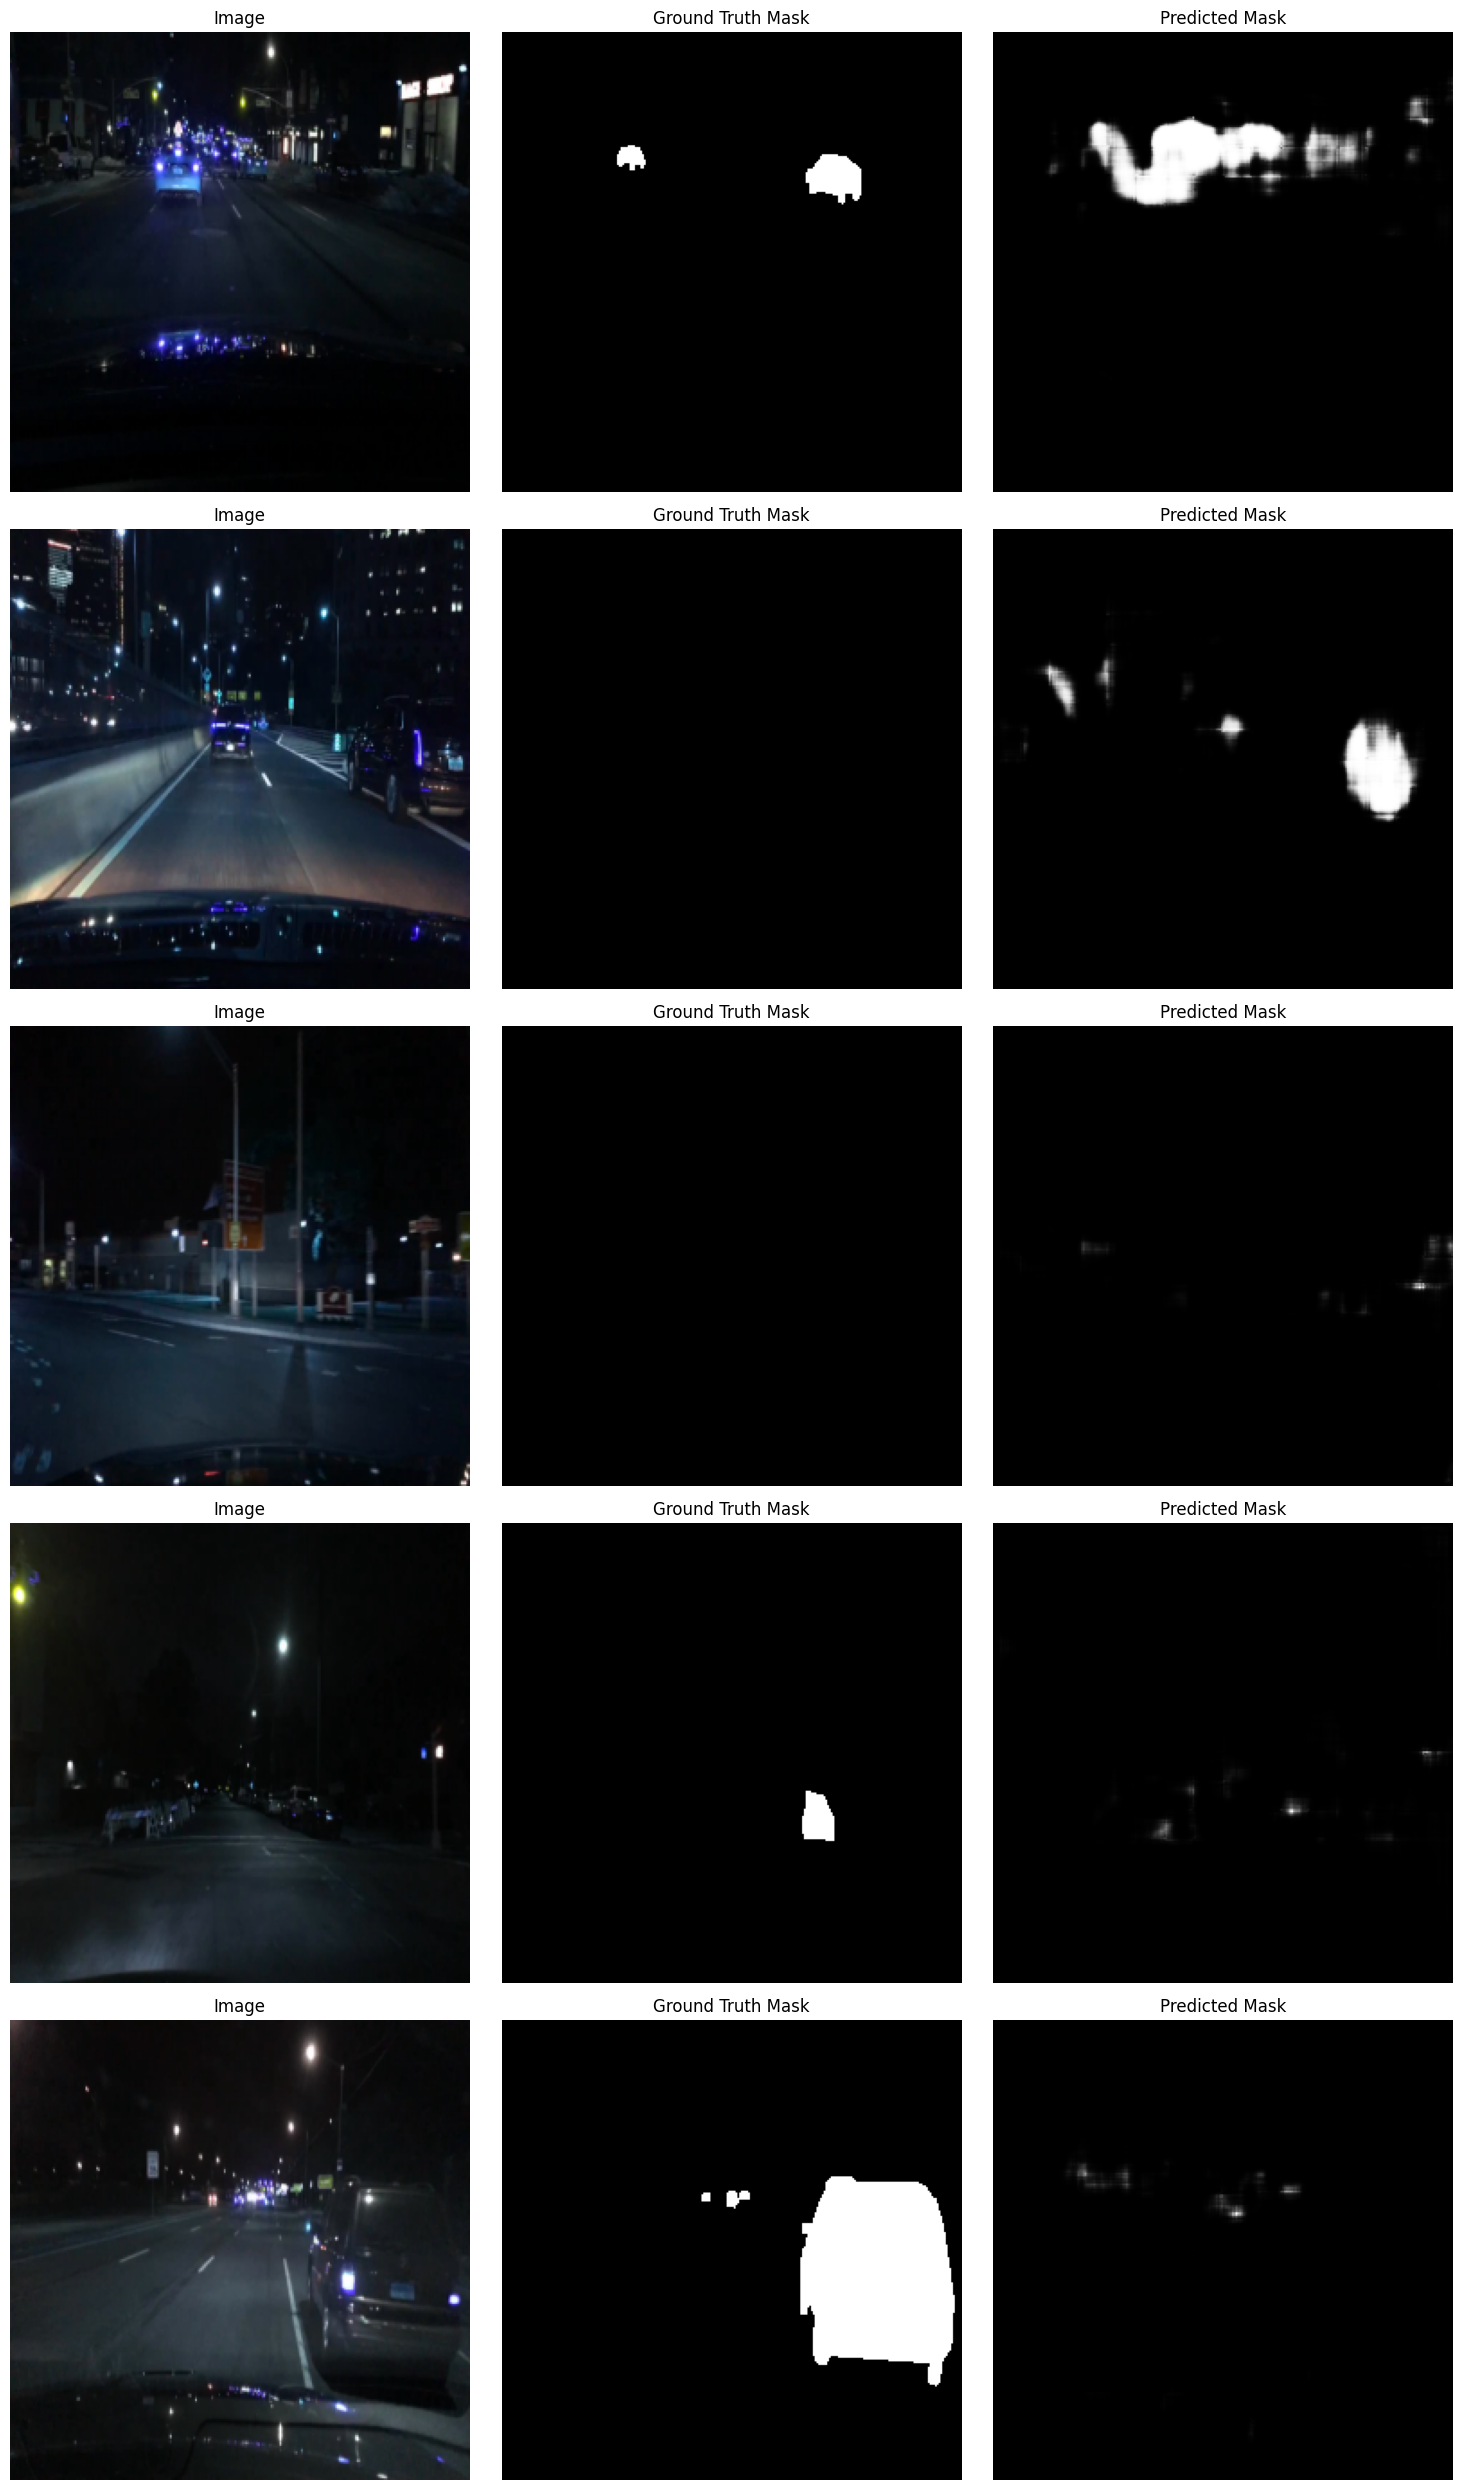

In [31]:
plot_images_masks_predictions(images, masks, predicted_mask)

# Fine Tuning the model for night time images.

In [32]:
def load_pretrained_model(model_path):

  def dice_loss(y_true, y_pred, smooth=1e-6):
      y_true_f = tf.keras.backend.flatten(y_true)
      y_pred_f = tf.keras.backend.flatten(y_pred)
      intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
      dice = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
      return 1 - dice

  new_model = tf.keras.models.load_model(
      model_path,
      custom_objects={'dice_loss': dice_loss},
      safe_mode=False  # Allow lambda loading
  )

  return new_model


In [33]:
def freeze_layers(model):
    for layer in model.layers[:5]:
        layer.trainable = False

    for layer in model.layers[-5:]:
        layer.trainable = True

    return model


In [34]:
def adjust_final_layer(model, num_classes):
    x = model.layers[-2].output
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(x)
    return tf.keras.Model(inputs=model.inputs, outputs=outputs)


In [35]:
def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [36]:
def fine_tune_model(model, images, masks, epochs=10, batch_size=32):
    history = model.fit(
        x=images,
        y=masks,
        epochs=epochs,
        batch_size=batch_size
    )
    return model, history

Edit with your night images and night masks folders.

In [37]:
image_folder = "/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Datasets/BDD100k/bdd100k/bdd100k/images/100k/night"
mask_folder = "/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Datasets/BDD100k/bdd100k_ins_seg/bdd100k/labels/ins_seg/colormaps/night"

In [38]:
images, masks = load_and_clean_data(image_folder, mask_folder, max_images=600)

Loaded 100 image-mask pairs.


In [39]:
# Load pre-trained model
model = load_pretrained_model(model_path='/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Models/Xception_unet_3.keras')

# Freeze encoder layers
model = freeze_layers(model)

# model = adjust_final_layer(model, num_classes=3)

# Compile the model
model = compile_model(model)

In [40]:
# Fine-tune the model
fine_tuned_model, history = fine_tune_model(model, images, masks, epochs=50)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.9461 - loss: 0.3821
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 205ms/step - accuracy: 0.9599 - loss: 0.2124
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.9522 - loss: 0.1717
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.9519 - loss: 0.1570
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.9584 - loss: 0.1390
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.9645 - loss: 0.1194
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.9655 - loss: 0.1111
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.9697 - loss: 0.0931
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.9724 - loss: 0.0862
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.9729 - loss: 0.0801
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.9767 - loss: 0.0708
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.9757 - los

In [41]:
# Save the fine-tuned model
# fine_tuned_model.save('fine_tuned_unet.h5')

In [42]:
predicted_mask = fine_tuned_model.predict(images)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 564ms/step


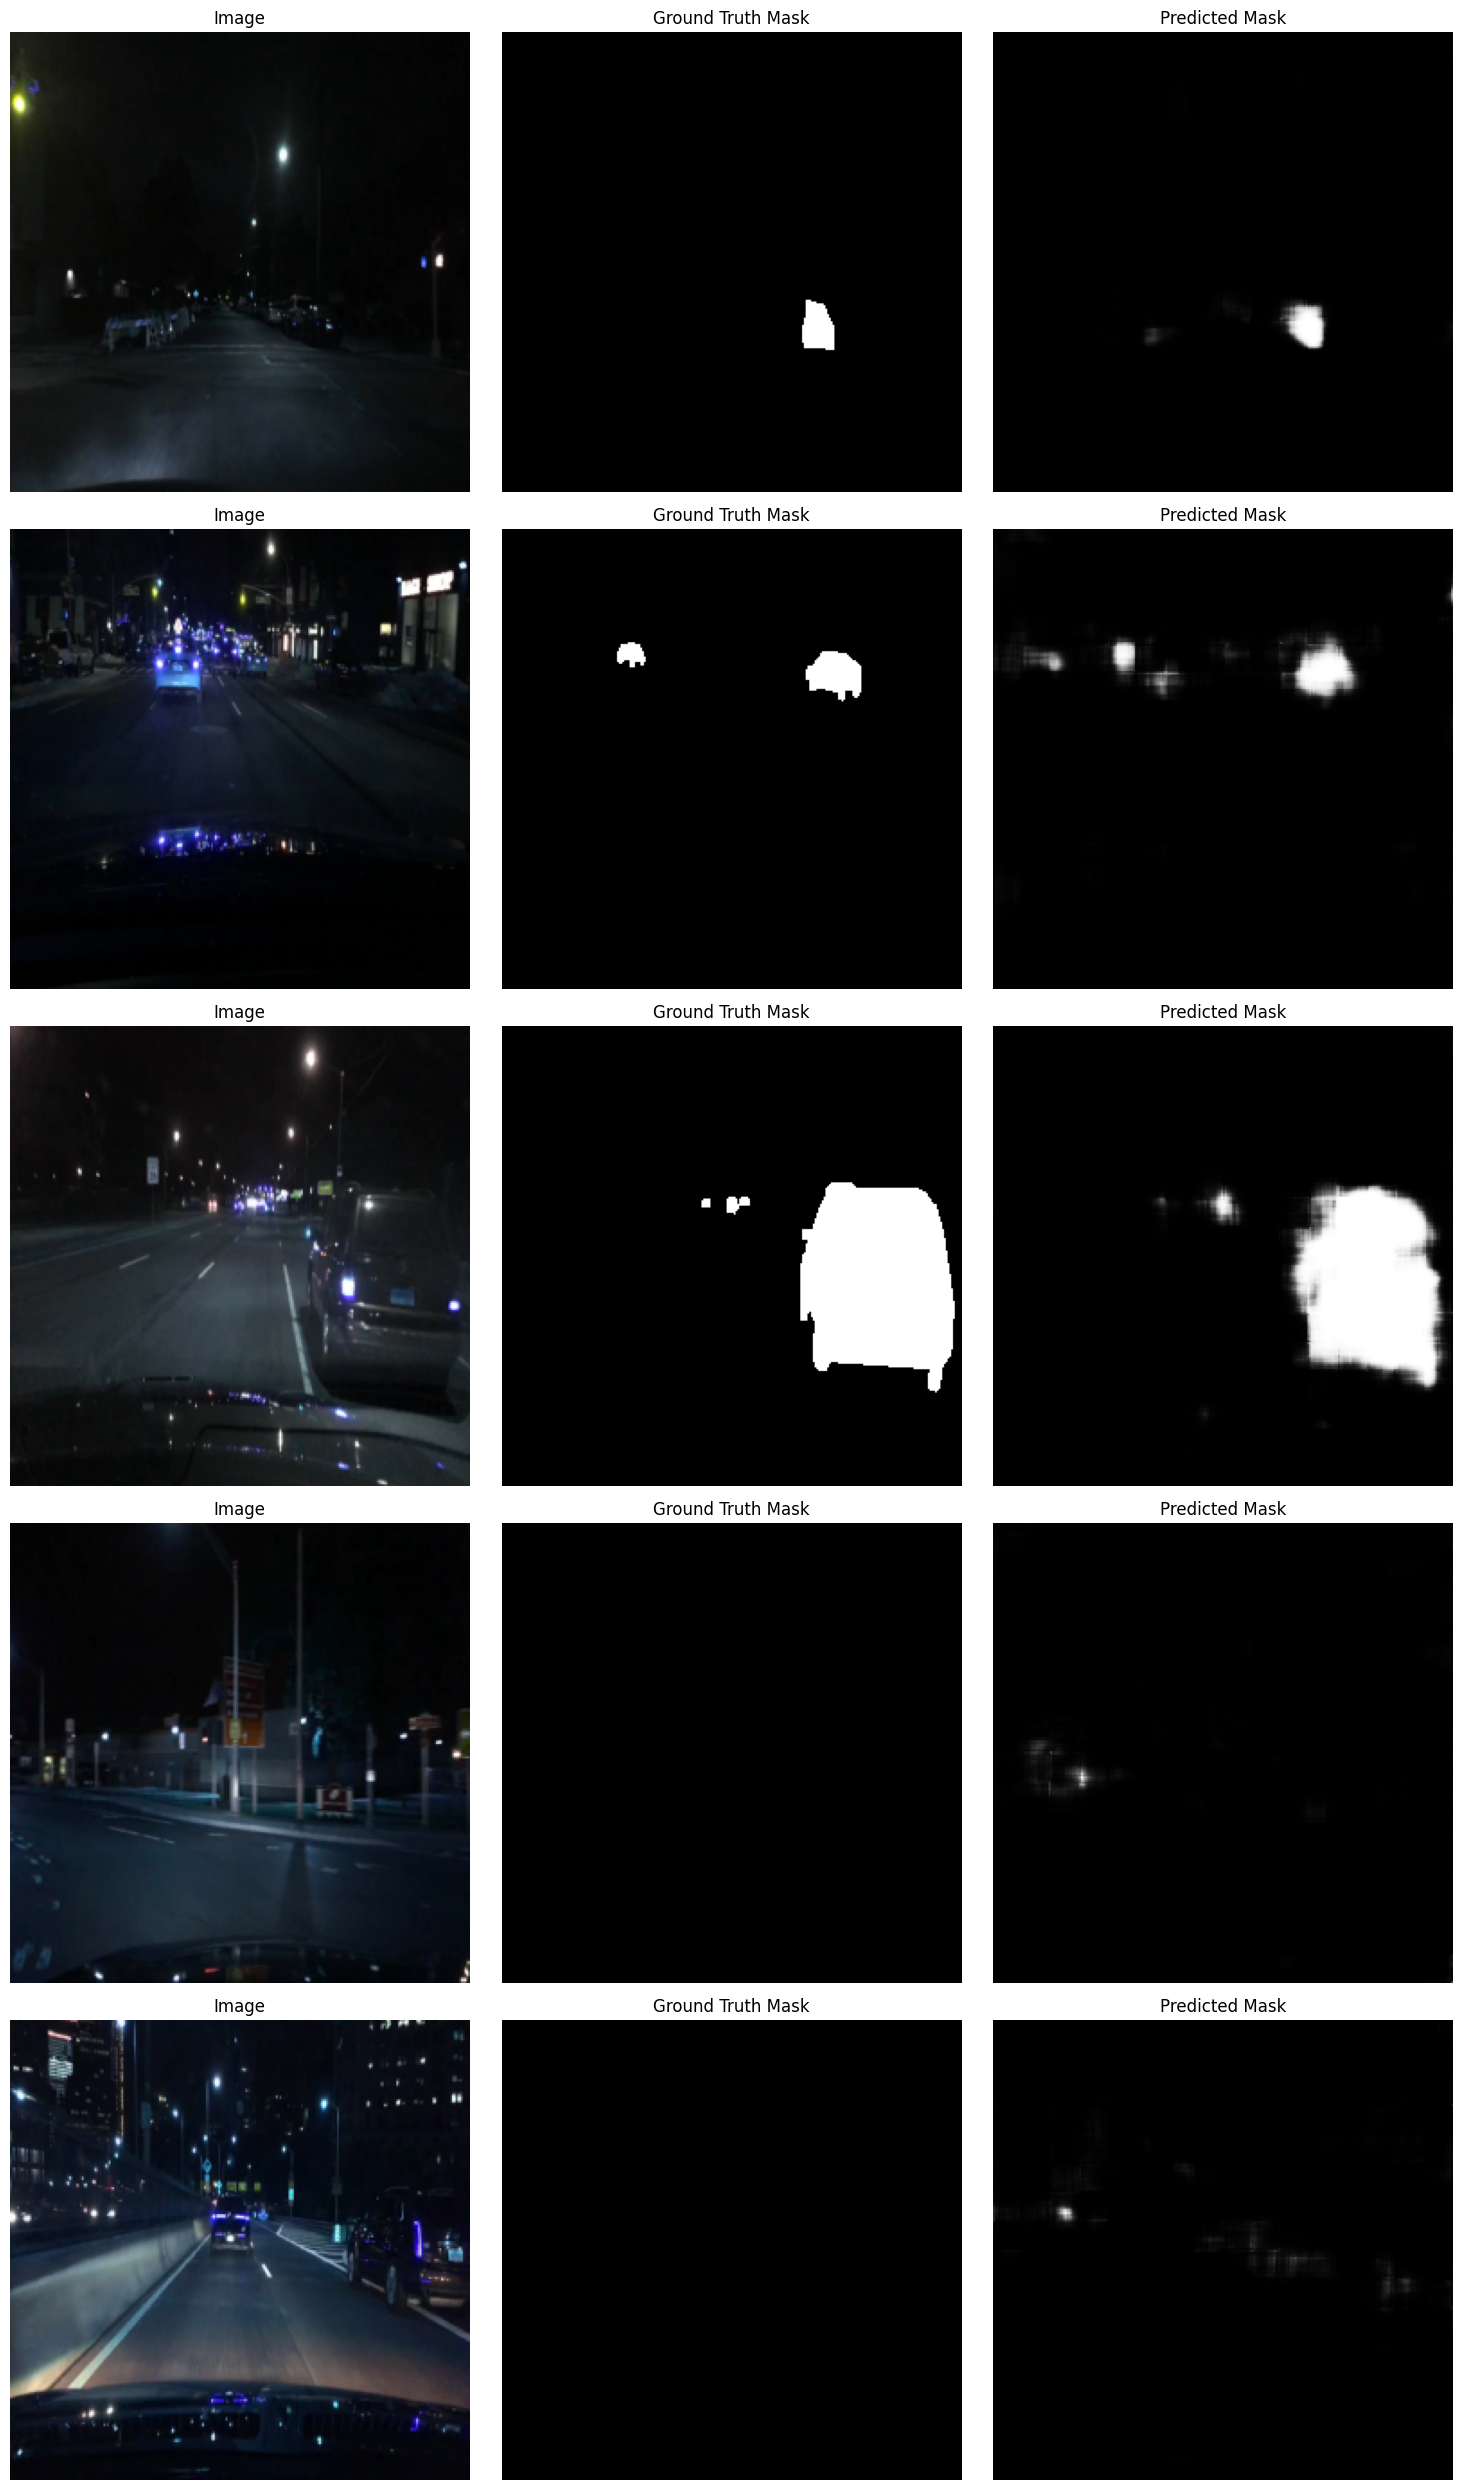

In [43]:
plot_images_masks_predictions(images, masks, predicted_mask)

In [44]:
model.save("/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/MobileNetV3_unet_3_fine_tuned.keras")